# train.ipynb: 用所有的训练集训练决策树
这里需要用到预处理过的数据，以减少代码运算时间。请先跑`waveform.py`。

In [27]:
import multiprocessing
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
%matplotlib inline
from utils import loadData, getNum, getPePerWF, saveData, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包

`waveform.py`预处理后的数据在./train中，文件名格式为`f"final_{i}_wf.h5"`

In [3]:
trainPathRoot = './data/final-'
processedPathRoot = './train/final_'

从预处理的数据中，读取训练两个训练集需要的原始数据，并将18个训练集的数据拼接起来。
1. `intTrainWF`: 波形积分
2. `pointsPerTrainWF`: 超过阈值的点数
3. `pePerTrainWFCalc`: 每个波形对应的PE数计算值
4. `meanPeTimePerTrainWF`: 每个波形对应的PETime的手算平均值
5. `pePerTrainWF`: 每个波形对应的PE数真值
6. `wfIndices`: (n+1,)的ndarray，下标为i表示EventID=i的第一次出现在Waveform表中的下标，下标为n表示Waveform表长度

In [4]:
intTrainWF = np.array([], dtype='<i4') # 读取波形积分
pointsPerTrainWF = np.array([], dtype='<i2') # 读取超过阈值的点数
pePerTrainWFCalc = np.array([], dtype='<i2') # 读取每个波形对应的PE数计算值
meanPeTimePerTrainWF = np.array([], dtype='<f8') # 读取每个波形对应的PETime的手算平均值
pePerTrainWF = np.array([], dtype='<i2') # 读取每个波形对应的PE数真值

wfIndices = np.array([0], dtype=int)
p = np.array([], dtype='<f8')

previousIndex = 0
for i in tqdm(range(2, 20)):
    with h5py.File(f"{processedPathRoot}{i}_wf.h5", 'r') as ipt:
        intTrainWF = np.append(intTrainWF, ipt['Waveform']['intWF'][...])
        pointsPerTrainWF = np.append(pointsPerTrainWF, ipt['Waveform']['pointsPerWF'][...])
        pePerTrainWFCalc = np.append(pePerTrainWFCalc, ipt['Waveform']['pePerWFCalc'][...])
        meanPeTimePerTrainWF = np.append(meanPeTimePerTrainWF, ipt['Waveform']['meanPeTimePerWF'][...])
        pePerTrainWF = np.append(pePerTrainWF, ipt['Waveform']['pePerWF'][...])
        
        wfIndicesChunk = ipt['WfIndices'][...]
        trainPT = loadData(f"./data/final-{i}.h5", 'p')
        
        wfIndices = np.append(wfIndices, np.zeros(trainPT.shape[0]))
        p = np.append(p, np.zeros(trainPT.shape[0]))
        finalIndex = previousIndex + trainPT.shape[0] + 1
        wfIndices[previousIndex:finalIndex] = wfIndicesChunk + wfIndices[previousIndex]
        p[previousIndex:(finalIndex-1)] = trainPT['p']
        previousIndex = finalIndex-1

  6%|▌         | 1/18 [00:00<00:11,  1.47it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


 11%|█         | 2/18 [00:01<00:10,  1.46it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9222643,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6021458,), type "|V2008"> Waveform /Waveform


 17%|█▋        | 3/18 [00:02<00:10,  1.39it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9009875,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5987414,), type "|V2008"> Waveform /Waveform


 22%|██▏       | 4/18 [00:02<00:10,  1.33it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9147704,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6004696,), type "|V2008"> Waveform /Waveform


 28%|██▊       | 5/18 [00:03<00:09,  1.34it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9262473,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6115519,), type "|V2008"> Waveform /Waveform


 33%|███▎      | 6/18 [00:04<00:09,  1.30it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9216927,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6075119,), type "|V2008"> Waveform /Waveform


 39%|███▉      | 7/18 [00:05<00:08,  1.30it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9103034,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5990370,), type "|V2008"> Waveform /Waveform


 44%|████▍     | 8/18 [00:06<00:07,  1.27it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9139087,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5965634,), type "|V2008"> Waveform /Waveform


 50%|█████     | 9/18 [00:06<00:07,  1.24it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9067611,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1999,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5965655,), type "|V2008"> Waveform /Waveform


 56%|█████▌    | 10/18 [00:07<00:06,  1.22it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9219415,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6039820,), type "|V2008"> Waveform /Waveform


 61%|██████    | 11/18 [00:08<00:05,  1.17it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9141287,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5995751,), type "|V2008"> Waveform /Waveform


 67%|██████▋   | 12/18 [00:09<00:05,  1.10it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9157071,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5984516,), type "|V2008"> Waveform /Waveform


 72%|███████▏  | 13/18 [00:10<00:04,  1.13it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9191741,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1998,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6020168,), type "|V2008"> Waveform /Waveform


 78%|███████▊  | 14/18 [00:11<00:03,  1.14it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9143911,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6038985,), type "|V2008"> Waveform /Waveform


 83%|████████▎ | 15/18 [00:12<00:02,  1.13it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9219236,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1999,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6039233,), type "|V2008"> Waveform /Waveform


 89%|████████▉ | 16/18 [00:13<00:01,  1.10it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9104863,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5981409,), type "|V2008"> Waveform /Waveform


 94%|█████████▍| 17/18 [00:14<00:00,  1.07it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9202609,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6058586,), type "|V2008"> Waveform /Waveform


100%|██████████| 18/18 [00:15<00:00,  1.17it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9261569,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6085040,), type "|V2008"> Waveform /Waveform


下面的代码和`model.ipynb`是完全一样的，除了训练集、验证集大小不一样。

In [9]:
trainDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[:-10000000], pointsPerTrainWF[:-10000000], pePerTrainWFCalc[:-10000000]),
        axis=1
    ),
    label=pePerTrainWF[:-10000000],
)
validationDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[-10000000:], pointsPerTrainWF[-10000000:], pePerTrainWFCalc[-10000000:]),
        axis=1
    ),
    label=pePerTrainWF[-10000000:],
    reference=trainDataForPePerWF,
)
trainDataForPePerWF.save_binary('./train/trainPePerWF.bin')
validationDataForPePerWF.save_binary('./train/validPePerWF.bin')

[LightGBM] [Info] Saving data to binary file ./train/trainPePerWF.bin


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Saving data to binary file ./train/validPePerWF.bin


In [10]:
trainDataForPePerWF = lgb.Dataset('./train/trainPePerWF.bin')
validationDataForPePerWF = lgb.Dataset('./train/validPePerWF.bin', reference=trainDataForPePerWF)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForPePerWF = lgb.train(
    params,
    trainDataForPePerWF,
    num_boost_round=3000,
    valid_sets=validationDataForPePerWF,
    early_stopping_rounds=100,
)
gbmForPePerWF.save_model('modelPePerWF.txt')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.465467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 1.82572
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.80789
[3]	valid_0's rmse: 1.79023
[4]	valid_0's rmse: 1.77276
[5]	valid_0's rmse: 1.75547
[6]	valid_0's rmse: 1.73836
[7]	valid_0's rmse: 1.72142
[8]	valid_0's rmse: 1.70466
[9]	valid_0's rmse: 1.68806
[10]	valid_0's rmse: 1.67164
[11]	valid_0's rmse: 1.65539
[12]	valid_0's rmse: 1.6393
[13]	valid_0's rmse: 1.62338
[14]	valid_0's rmse: 1.60763
[15]	valid_0's rmse: 1.59203
[16]	valid_0's rmse: 1.5766
[17]	valid_0's rmse: 1.56132
[18]	valid_0's rmse: 1.54621
[19]	valid_0's rmse: 1.53124
[20]	valid_0's rmse: 1.51644
[21]	valid_0's rmse: 1.50178
[22]	valid_0's rmse: 1.48728
[23]	valid_0's rmse: 1.47293
[24]	valid_0's rmse: 1.45873
[25]	valid_0's rmse: 1.4

[263]	valid_0's rmse: 0.306831
[264]	valid_0's rmse: 0.306286
[265]	valid_0's rmse: 0.305752
[266]	valid_0's rmse: 0.305227
[267]	valid_0's rmse: 0.304712
[268]	valid_0's rmse: 0.304206
[269]	valid_0's rmse: 0.303709
[270]	valid_0's rmse: 0.303222
[271]	valid_0's rmse: 0.302743
[272]	valid_0's rmse: 0.302273
[273]	valid_0's rmse: 0.301812
[274]	valid_0's rmse: 0.30136
[275]	valid_0's rmse: 0.300916
[276]	valid_0's rmse: 0.30048
[277]	valid_0's rmse: 0.300052
[278]	valid_0's rmse: 0.299632
[279]	valid_0's rmse: 0.29922
[280]	valid_0's rmse: 0.298815
[281]	valid_0's rmse: 0.298418
[282]	valid_0's rmse: 0.298029
[283]	valid_0's rmse: 0.297646
[284]	valid_0's rmse: 0.297271
[285]	valid_0's rmse: 0.296903
[286]	valid_0's rmse: 0.296542
[287]	valid_0's rmse: 0.296188
[288]	valid_0's rmse: 0.29584
[289]	valid_0's rmse: 0.295498
[290]	valid_0's rmse: 0.295164
[291]	valid_0's rmse: 0.294835
[292]	valid_0's rmse: 0.294513
[293]	valid_0's rmse: 0.294197
[294]	valid_0's rmse: 0.293886
[295]	valid_

[529]	valid_0's rmse: 0.278409
[530]	valid_0's rmse: 0.278406
[531]	valid_0's rmse: 0.278404
[532]	valid_0's rmse: 0.278402
[533]	valid_0's rmse: 0.278399
[534]	valid_0's rmse: 0.278397
[535]	valid_0's rmse: 0.278395
[536]	valid_0's rmse: 0.278392
[537]	valid_0's rmse: 0.27839
[538]	valid_0's rmse: 0.278388
[539]	valid_0's rmse: 0.278386
[540]	valid_0's rmse: 0.278384
[541]	valid_0's rmse: 0.278382
[542]	valid_0's rmse: 0.27838
[543]	valid_0's rmse: 0.278378
[544]	valid_0's rmse: 0.278376
[545]	valid_0's rmse: 0.278374
[546]	valid_0's rmse: 0.278373
[547]	valid_0's rmse: 0.278371
[548]	valid_0's rmse: 0.278369
[549]	valid_0's rmse: 0.278368
[550]	valid_0's rmse: 0.278366
[551]	valid_0's rmse: 0.278364
[552]	valid_0's rmse: 0.278363
[553]	valid_0's rmse: 0.278361
[554]	valid_0's rmse: 0.27836
[555]	valid_0's rmse: 0.278358
[556]	valid_0's rmse: 0.278357
[557]	valid_0's rmse: 0.278356
[558]	valid_0's rmse: 0.278354
[559]	valid_0's rmse: 0.278353
[560]	valid_0's rmse: 0.278352
[561]	valid

In [13]:
gbmForPePerWF = lgb.Booster(model_file='./modelPePerWF.txt')
pePerTrainWFFinal = gbmForPePerWF.predict(
    np.stack(
        (intTrainWF, pointsPerTrainWF, pePerTrainWFCalc),
        axis=1
    )
)

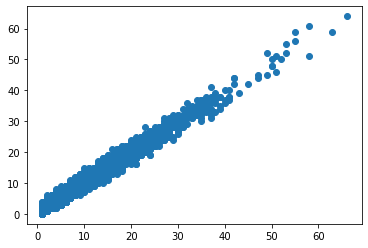

In [32]:
model = LinearRegression()
model.fit(intTrainWF.reshape(-1, 1), pePerTrainWF)
pePerTrainWFInt = np.round(model.predict(intTrainWF.reshape(-1,1)))
plt.scatter(pePerTrainWFInt[:600000], pePerTrainWF[:600000])
plt.show()

In [41]:
print(model.coef_)
print(model.intercept_)

[0.00651683]
0.5644330147776138


In [33]:
# splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1].astype(int))
splitPePerTrainWFFinal = np.split(pePerTrainWFInt, wfIndices[1:-1].astype(int))
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1].astype(int))
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)

100%|██████████| 35996/35996 [00:06<00:00, 5390.56it/s]


In [43]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-3600], peMean[:-3600], peStd[:-3600], peTimeMean[:-3600], peTimeStd[:-3600]),
        axis=1
    ),
    label=p[:-3600]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-3600:], peMean[-3600:], peStd[-3600:], peTimeMean[-3600:], peTimeStd[-3600:]),
        axis=1
    ),
    label=p[-3600:],
    reference=trainDataForP
)
trainDataForP.save_binary('./train/trainDataForPPrune.bin')
validationDataForP.save_binary('./train/validDataForPPrune.bin')

[LightGBM] [Warning] File ./train/trainDataForPPrune.bin exists, cannot save binary to it
[LightGBM] [Info] Saving data to binary file ./train/validDataForPPrune.bin


In [44]:
trainDataForP = lgb.Dataset('./train/trainDataForPPrune.bin')
validationDataForP = lgb.Dataset('./train/validDataForPPrune.bin')

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**15,
    'learning_rate': 0.001,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 10,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=60000,
    valid_sets=validationDataForP,
    early_stopping_rounds=300,
    fobj=lossfunc_train,
    feval=lossfunc_eval
)
gbmForP.save_model('modelPInt.txt')

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 6.20221	valid_0's custom: 5.47572
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 6.19602	valid_0's custom: 5.46479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.18984	valid_0's custom: 5.45388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.18366	valid_0's custom: 5.44299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's rmse: 5.80679	valid_0's custom: 4.79921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's rmse: 5.801	valid_0's custom: 4.78963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's rmse: 5.79522	valid_0's custom: 4.78008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's rmse: 5.78944	valid_0's custom: 4.77054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's rmse: 5.78366	valid_0's custom: 4.76102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's rmse: 5.77789	valid_0's custom: 4.75152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's rmse: 5.77213	valid_0's custom: 4.74204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's rm

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's rmse: 5.43139	valid_0's custom: 4.19822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's rmse: 5.42597	valid_0's custom: 4.18984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's rmse: 5.42056	valid_0's custom: 4.18149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's rmse: 5.41516	valid_0's custom: 4.17315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's rmse: 5.40976	valid_0's custom: 4.16482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's rmse: 5.40436	valid_0's custom: 4.15651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's rmse: 5.39898	valid_0's custom: 4.14823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's rmse: 5.07526	valid_0's custom: 3.66529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's rmse: 5.0702	valid_0's custom: 3.65798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's rmse: 5.06514	valid_0's custom: 3.65068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's rmse: 5.06009	valid_0's custom: 3.64341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's rmse: 5.05505	valid_0's custom: 3.63614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's rmse: 5.05001	valid_0's custom: 3.62889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's rmse: 5.04498	valid_0's custom: 3.62165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's rmse: 4.73779	valid_0's custom: 3.19364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's rmse: 4.73307	valid_0's custom: 3.18727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's rmse: 4.72835	valid_0's custom: 3.18092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's rmse: 4.72364	valid_0's custom: 3.17458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's rmse: 4.71893	valid_0's custom: 3.16825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's rmse: 4.71423	valid_0's custom: 3.16193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's rmse: 4.70953	valid_0's custom: 3.15562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	valid_0's rmse: 4.43173	valid_0's custom: 2.79396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's rmse: 4.42732	valid_0's custom: 2.78839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	valid_0's rmse: 4.42291	valid_0's custom: 2.78283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	valid_0's rmse: 4.4185	valid_0's custom: 2.77729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	valid_0's rmse: 4.4141	valid_0's custom: 2.77175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	valid_0's rmse: 4.4097	valid_0's custom: 2.76623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[344]	valid_0's rmse: 4.40531	valid_0's custom: 2.76071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[405]	valid_0's rmse: 4.14558	valid_0's custom: 2.44444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's rmse: 4.14145	valid_0's custom: 2.43957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's rmse: 4.13733	valid_0's custom: 2.43471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's rmse: 4.13321	valid_0's custom: 2.42986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's rmse: 4.12909	valid_0's custom: 2.42502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's rmse: 4.12498	valid_0's custom: 2.42019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's rmse: 4.12087	valid_0's custom: 2.41537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's rmse: 3.87415	valid_0's custom: 2.13451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[474]	valid_0's rmse: 3.87029	valid_0's custom: 2.13026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[475]	valid_0's rmse: 3.86644	valid_0's custom: 2.12602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[476]	valid_0's rmse: 3.86259	valid_0's custom: 2.12179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[477]	valid_0's rmse: 3.85875	valid_0's custom: 2.11756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[478]	valid_0's rmse: 3.85491	valid_0's custom: 2.11334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[479]	valid_0's rmse: 3.85107	valid_0's custom: 2.10914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[480]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's rmse: 3.61706	valid_0's custom: 1.86034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's rmse: 3.61346	valid_0's custom: 1.85664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's rmse: 3.60987	valid_0's custom: 1.85294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[545]	valid_0's rmse: 3.60628	valid_0's custom: 1.84926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	valid_0's rmse: 3.60269	valid_0's custom: 1.84558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	valid_0's rmse: 3.59911	valid_0's custom: 1.84191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[548]	valid_0's rmse: 3.59553	valid_0's custom: 1.83824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[549]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 3.38388	valid_0's custom: 1.62798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's rmse: 3.38052	valid_0's custom: 1.62474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[611]	valid_0's rmse: 3.37716	valid_0's custom: 1.62151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[612]	valid_0's rmse: 3.37381	valid_0's custom: 1.61829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[613]	valid_0's rmse: 3.37045	valid_0's custom: 1.61507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[614]	valid_0's rmse: 3.3671	valid_0's custom: 1.61186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[615]	valid_0's rmse: 3.36376	valid_0's custom: 1.60865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[616]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[676]	valid_0's rmse: 3.16588	valid_0's custom: 1.42477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[677]	valid_0's rmse: 3.16274	valid_0's custom: 1.42194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[678]	valid_0's rmse: 3.1596	valid_0's custom: 1.41912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[679]	valid_0's rmse: 3.15646	valid_0's custom: 1.4163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[680]	valid_0's rmse: 3.15332	valid_0's custom: 1.41348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[681]	valid_0's rmse: 3.15019	valid_0's custom: 1.41067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[682]	valid_0's rmse: 3.14706	valid_0's custom: 1.40787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[683]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's rmse: 2.97091	valid_0's custom: 1.25452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's rmse: 2.96796	valid_0's custom: 1.25203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	valid_0's rmse: 2.96501	valid_0's custom: 1.24954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[743]	valid_0's rmse: 2.96207	valid_0's custom: 1.24706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[744]	valid_0's rmse: 2.95913	valid_0's custom: 1.24458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[745]	valid_0's rmse: 2.9562	valid_0's custom: 1.24211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[746]	valid_0's rmse: 2.95326	valid_0's custom: 1.23965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[747]	val

[810]	valid_0's rmse: 2.77157	valid_0's custom: 1.09166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's rmse: 2.76882	valid_0's custom: 1.0895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's rmse: 2.76607	valid_0's custom: 1.08734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's rmse: 2.76333	valid_0's custom: 1.08518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's rmse: 2.7606	valid_0's custom: 1.08303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's rmse: 2.75786	valid_0's custom: 1.08088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's rmse: 2.75513	valid_0's custom: 1.07874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's rmse: 2.7524	valid_0's custom: 1.0766
[LightGBM] [Warning] No further

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[875]	valid_0's rmse: 2.59864	valid_0's custom: 0.959568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[876]	valid_0's rmse: 2.59607	valid_0's custom: 0.957667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[877]	valid_0's rmse: 2.5935	valid_0's custom: 0.955769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's rmse: 2.59093	valid_0's custom: 0.953876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's rmse: 2.58836	valid_0's custom: 0.951986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's rmse: 2.5858	valid_0's custom: 0.9501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 2.58324	valid_0's custom: 0.948218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[940]	valid_0's rmse: 2.43666	valid_0's custom: 0.843573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[941]	valid_0's rmse: 2.43425	valid_0's custom: 0.841903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[942]	valid_0's rmse: 2.43185	valid_0's custom: 0.840237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[943]	valid_0's rmse: 2.42944	valid_0's custom: 0.838574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[944]	valid_0's rmse: 2.42704	valid_0's custom: 0.836915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[945]	valid_0's rmse: 2.42464	valid_0's custom: 0.83526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[946]	valid_0's rmse: 2.42224	valid_0's custom: 0.833607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1005]	valid_0's rmse: 2.28497	valid_0's custom: 0.741725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1006]	valid_0's rmse: 2.28272	valid_0's custom: 0.74026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1007]	valid_0's rmse: 2.28046	valid_0's custom: 0.738796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1008]	valid_0's rmse: 2.27821	valid_0's custom: 0.737336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1009]	valid_0's rmse: 2.27596	valid_0's custom: 0.735879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1010]	valid_0's rmse: 2.27371	valid_0's custom: 0.734426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1011]	valid_0's rmse: 2.27147	valid_0's custom: 0.732975
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1071]	valid_0's rmse: 2.14081	valid_0's custom: 0.65101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1072]	valid_0's rmse: 2.1387	valid_0's custom: 0.649725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1073]	valid_0's rmse: 2.13659	valid_0's custom: 0.648443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1074]	valid_0's rmse: 2.13449	valid_0's custom: 0.647164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1075]	valid_0's rmse: 2.13238	valid_0's custom: 0.645887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1076]	valid_0's rmse: 2.13028	valid_0's custom: 0.644613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's rmse: 2.12818	valid_0's custom: 0.643342
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1137]	valid_0's rmse: 2.00597	valid_0's custom: 0.571524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1138]	valid_0's rmse: 2.004	valid_0's custom: 0.570399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1139]	valid_0's rmse: 2.00203	valid_0's custom: 0.569275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1140]	valid_0's rmse: 2.00006	valid_0's custom: 0.568154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1141]	valid_0's rmse: 1.99809	valid_0's custom: 0.567036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1142]	valid_0's rmse: 1.99612	valid_0's custom: 0.565919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 1.99416	valid_0's custom: 0.564806
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1201]	valid_0's rmse: 1.88355	valid_0's custom: 0.503853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1202]	valid_0's rmse: 1.8817	valid_0's custom: 0.502864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1203]	valid_0's rmse: 1.87985	valid_0's custom: 0.501875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1204]	valid_0's rmse: 1.878	valid_0's custom: 0.500888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1205]	valid_0's rmse: 1.87615	valid_0's custom: 0.499904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1206]	valid_0's rmse: 1.87431	valid_0's custom: 0.498922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1207]	valid_0's rmse: 1.87247	valid_0's custom: 0.497941
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1267]	valid_0's rmse: 1.76532	valid_0's custom: 0.442566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1268]	valid_0's rmse: 1.76358	valid_0's custom: 0.441698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1269]	valid_0's rmse: 1.76186	valid_0's custom: 0.440832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1270]	valid_0's rmse: 1.76013	valid_0's custom: 0.439968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1271]	valid_0's rmse: 1.7584	valid_0's custom: 0.439106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1272]	valid_0's rmse: 1.75668	valid_0's custom: 0.438244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1273]	valid_0's rmse: 1.75496	valid_0's custom: 0.437386
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1332]	valid_0's rmse: 1.65636	valid_0's custom: 0.389619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1333]	valid_0's rmse: 1.65474	valid_0's custom: 0.388857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1334]	valid_0's rmse: 1.65312	valid_0's custom: 0.388096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1335]	valid_0's rmse: 1.6515	valid_0's custom: 0.387337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1336]	valid_0's rmse: 1.64989	valid_0's custom: 0.386579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1337]	valid_0's rmse: 1.64827	valid_0's custom: 0.385823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1338]	valid_0's rmse: 1.64666	valid_0's custom: 0.385069
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1398]	valid_0's rmse: 1.55289	valid_0's custom: 0.342472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1399]	valid_0's rmse: 1.55137	valid_0's custom: 0.341805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1400]	valid_0's rmse: 1.54986	valid_0's custom: 0.341139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1401]	valid_0's rmse: 1.54835	valid_0's custom: 0.340474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1402]	valid_0's rmse: 1.54684	valid_0's custom: 0.33981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1403]	valid_0's rmse: 1.54533	valid_0's custom: 0.339148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1404]	valid_0's rmse: 1.54383	valid_0's custom: 0.338488
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1471]	valid_0's rmse: 1.44631	valid_0's custom: 0.297103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1472]	valid_0's rmse: 1.4449	valid_0's custom: 0.296526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1473]	valid_0's rmse: 1.4435	valid_0's custom: 0.29595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1474]	valid_0's rmse: 1.4421	valid_0's custom: 0.295376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1475]	valid_0's rmse: 1.4407	valid_0's custom: 0.294803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1476]	valid_0's rmse: 1.4393	valid_0's custom: 0.294231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1477]	valid_0's rmse: 1.4379	valid_0's custom: 0.29366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1540]	valid_0's rmse: 1.35265	valid_0's custom: 0.259906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1541]	valid_0's rmse: 1.35134	valid_0's custom: 0.259403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1542]	valid_0's rmse: 1.35003	valid_0's custom: 0.258902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1543]	valid_0's rmse: 1.34873	valid_0's custom: 0.258402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's rmse: 1.34742	valid_0's custom: 0.257903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's rmse: 1.34612	valid_0's custom: 0.257405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's rmse: 1.34481	valid_0's custom: 0.256908
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1605]	valid_0's rmse: 1.27031	valid_0's custom: 0.229271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1606]	valid_0's rmse: 1.26908	valid_0's custom: 0.22883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1607]	valid_0's rmse: 1.26786	valid_0's custom: 0.228389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1608]	valid_0's rmse: 1.26664	valid_0's custom: 0.22795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1609]	valid_0's rmse: 1.26542	valid_0's custom: 0.227512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1610]	valid_0's rmse: 1.2642	valid_0's custom: 0.227075
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1611]	valid_0's rmse: 1.26298	valid_0's custom: 0.226638
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1675]	valid_0's rmse: 1.18761	valid_0's custom: 0.200444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1676]	valid_0's rmse: 1.18647	valid_0's custom: 0.200061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1677]	valid_0's rmse: 1.18533	valid_0's custom: 0.199679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1678]	valid_0's rmse: 1.1842	valid_0's custom: 0.199297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1679]	valid_0's rmse: 1.18306	valid_0's custom: 0.198916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1680]	valid_0's rmse: 1.18193	valid_0's custom: 0.198536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1681]	valid_0's rmse: 1.1808	valid_0's custom: 0.198157
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1748]	valid_0's rmse: 1.10757	valid_0's custom: 0.174402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1749]	valid_0's rmse: 1.10651	valid_0's custom: 0.174071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1750]	valid_0's rmse: 1.10546	valid_0's custom: 0.173741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1751]	valid_0's rmse: 1.10441	valid_0's custom: 0.173411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1752]	valid_0's rmse: 1.10335	valid_0's custom: 0.173082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1753]	valid_0's rmse: 1.1023	valid_0's custom: 0.172754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1754]	valid_0's rmse: 1.10125	valid_0's custom: 0.172427
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1820]	valid_0's rmse: 1.03437	valid_0's custom: 0.152192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1821]	valid_0's rmse: 1.0334	valid_0's custom: 0.151906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1822]	valid_0's rmse: 1.03242	valid_0's custom: 0.15162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1823]	valid_0's rmse: 1.03144	valid_0's custom: 0.151335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1824]	valid_0's rmse: 1.03047	valid_0's custom: 0.15105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1825]	valid_0's rmse: 1.0295	valid_0's custom: 0.150766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1826]	valid_0's rmse: 1.02852	valid_0's custom: 0.150482
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1884]	valid_0's rmse: 0.973797	valid_0's custom: 0.134968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1885]	valid_0's rmse: 0.972883	valid_0's custom: 0.134716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1886]	valid_0's rmse: 0.971969	valid_0's custom: 0.134465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1887]	valid_0's rmse: 0.971057	valid_0's custom: 0.134214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1888]	valid_0's rmse: 0.970145	valid_0's custom: 0.133963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1889]	valid_0's rmse: 0.969235	valid_0's custom: 0.133713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1890]	valid_0's rmse: 0.968325	valid_0's custom: 0.133464
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1954]	valid_0's rmse: 0.912053	valid_0's custom: 0.11849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1955]	valid_0's rmse: 0.911204	valid_0's custom: 0.118271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1956]	valid_0's rmse: 0.910356	valid_0's custom: 0.118053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1957]	valid_0's rmse: 0.90951	valid_0's custom: 0.117835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1958]	valid_0's rmse: 0.908663	valid_0's custom: 0.117617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1959]	valid_0's rmse: 0.907817	valid_0's custom: 0.117399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1960]	valid_0's rmse: 0.906972	valid_0's custom: 0.117182
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2018]	valid_0's rmse: 0.859501	valid_0's custom: 0.105322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2019]	valid_0's rmse: 0.858708	valid_0's custom: 0.105129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2020]	valid_0's rmse: 0.857916	valid_0's custom: 0.104937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2021]	valid_0's rmse: 0.857125	valid_0's custom: 0.104745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2022]	valid_0's rmse: 0.856335	valid_0's custom: 0.104554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2023]	valid_0's rmse: 0.855545	valid_0's custom: 0.104363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2024]	valid_0's rmse: 0.854757	valid_0's custom: 0.104172
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2083]	valid_0's rmse: 0.809696	valid_0's custom: 0.093571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2084]	valid_0's rmse: 0.808957	valid_0's custom: 0.093402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2085]	valid_0's rmse: 0.808219	valid_0's custom: 0.0932332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2086]	valid_0's rmse: 0.807481	valid_0's custom: 0.0930648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2087]	valid_0's rmse: 0.806743	valid_0's custom: 0.0928966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2088]	valid_0's rmse: 0.806008	valid_0's custom: 0.0927289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2089]	valid_0's rmse: 0.805273	valid_0's custom: 0.0925616
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2149]	valid_0's rmse: 0.762606	valid_0's custom: 0.083111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2150]	valid_0's rmse: 0.761918	valid_0's custom: 0.0829629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2151]	valid_0's rmse: 0.761232	valid_0's custom: 0.0828152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2152]	valid_0's rmse: 0.760546	valid_0's custom: 0.0826678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2153]	valid_0's rmse: 0.759861	valid_0's custom: 0.0825206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2154]	valid_0's rmse: 0.759176	valid_0's custom: 0.0823737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2155]	valid_0's rmse: 0.758492	valid_0's custom: 0.0822271
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2222]	valid_0's rmse: 0.714319	valid_0's custom: 0.0730437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2223]	valid_0's rmse: 0.713684	valid_0's custom: 0.0729157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2224]	valid_0's rmse: 0.71305	valid_0's custom: 0.072788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2225]	valid_0's rmse: 0.712416	valid_0's custom: 0.0726605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2226]	valid_0's rmse: 0.711784	valid_0's custom: 0.0725334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2227]	valid_0's rmse: 0.711151	valid_0's custom: 0.0724064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2228]	valid_0's rmse: 0.71052	valid_0's custom: 0.0722798
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2294]	valid_0's rmse: 0.670352	valid_0's custom: 0.0644565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2295]	valid_0's rmse: 0.669765	valid_0's custom: 0.0643456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2296]	valid_0's rmse: 0.66918	valid_0's custom: 0.0642352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2297]	valid_0's rmse: 0.668595	valid_0's custom: 0.064125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2298]	valid_0's rmse: 0.668012	valid_0's custom: 0.064015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2299]	valid_0's rmse: 0.667429	valid_0's custom: 0.0639052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2300]	valid_0's rmse: 0.666847	valid_0's custom: 0.0637957
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2365]	valid_0's rmse: 0.630344	valid_0's custom: 0.0571234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2366]	valid_0's rmse: 0.629803	valid_0's custom: 0.0570274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2367]	valid_0's rmse: 0.629262	valid_0's custom: 0.0569316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2368]	valid_0's rmse: 0.628723	valid_0's custom: 0.056836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2369]	valid_0's rmse: 0.628183	valid_0's custom: 0.0567405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2370]	valid_0's rmse: 0.627644	valid_0's custom: 0.0566452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2371]	valid_0's rmse: 0.627107	valid_0's custom: 0.0565502
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2431]	valid_0's rmse: 0.595938	valid_0's custom: 0.0511833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2432]	valid_0's rmse: 0.595437	valid_0's custom: 0.0510992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2433]	valid_0's rmse: 0.594937	valid_0's custom: 0.0510153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2434]	valid_0's rmse: 0.594436	valid_0's custom: 0.0509315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2435]	valid_0's rmse: 0.593936	valid_0's custom: 0.0508479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2436]	valid_0's rmse: 0.593437	valid_0's custom: 0.0507645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2437]	valid_0's rmse: 0.592938	valid_0's custom: 0.0506811
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2498]	valid_0's rmse: 0.563596	valid_0's custom: 0.0459053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2499]	valid_0's rmse: 0.563132	valid_0's custom: 0.0458318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2500]	valid_0's rmse: 0.562669	valid_0's custom: 0.0457584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2501]	valid_0's rmse: 0.562206	valid_0's custom: 0.0456851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2502]	valid_0's rmse: 0.561744	valid_0's custom: 0.045612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2503]	valid_0's rmse: 0.561282	valid_0's custom: 0.0455391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2504]	valid_0's rmse: 0.560821	valid_0's custom: 0.0454664
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2570]	valid_0's rmse: 0.531563	valid_0's custom: 0.0409729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2571]	valid_0's rmse: 0.531137	valid_0's custom: 0.0409092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2572]	valid_0's rmse: 0.530712	valid_0's custom: 0.0408458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2573]	valid_0's rmse: 0.530287	valid_0's custom: 0.0407824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2574]	valid_0's rmse: 0.529862	valid_0's custom: 0.0407192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2575]	valid_0's rmse: 0.529438	valid_0's custom: 0.0406561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2576]	valid_0's rmse: 0.529015	valid_0's custom: 0.0405931
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2633]	valid_0's rmse: 0.505696	valid_0's custom: 0.0372046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2634]	valid_0's rmse: 0.505301	valid_0's custom: 0.0371485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2635]	valid_0's rmse: 0.504906	valid_0's custom: 0.0370926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2636]	valid_0's rmse: 0.504512	valid_0's custom: 0.0370368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2637]	valid_0's rmse: 0.504119	valid_0's custom: 0.0369811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2638]	valid_0's rmse: 0.503725	valid_0's custom: 0.0369254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2639]	valid_0's rmse: 0.503332	valid_0's custom: 0.0368699
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2700]	valid_0's rmse: 0.480269	valid_0's custom: 0.0336873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2701]	valid_0's rmse: 0.479906	valid_0's custom: 0.0336383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2702]	valid_0's rmse: 0.479543	valid_0's custom: 0.0335895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2703]	valid_0's rmse: 0.47918	valid_0's custom: 0.0335407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2704]	valid_0's rmse: 0.478817	valid_0's custom: 0.033492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2705]	valid_0's rmse: 0.478455	valid_0's custom: 0.0334434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2706]	valid_0's rmse: 0.478094	valid_0's custom: 0.0333949
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2761]	valid_0's rmse: 0.458857	valid_0's custom: 0.0308687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2762]	valid_0's rmse: 0.458519	valid_0's custom: 0.0308253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2763]	valid_0's rmse: 0.458183	valid_0's custom: 0.030782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2764]	valid_0's rmse: 0.457846	valid_0's custom: 0.0307389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2765]	valid_0's rmse: 0.45751	valid_0's custom: 0.0306958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2766]	valid_0's rmse: 0.457174	valid_0's custom: 0.0306526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2767]	valid_0's rmse: 0.456838	valid_0's custom: 0.0306096
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2822]	valid_0's rmse: 0.439014	valid_0's custom: 0.028374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2823]	valid_0's rmse: 0.438701	valid_0's custom: 0.0283356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2824]	valid_0's rmse: 0.43839	valid_0's custom: 0.0282974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2825]	valid_0's rmse: 0.438078	valid_0's custom: 0.0282591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2826]	valid_0's rmse: 0.437767	valid_0's custom: 0.0282209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2827]	valid_0's rmse: 0.437455	valid_0's custom: 0.0281828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2828]	valid_0's rmse: 0.437146	valid_0's custom: 0.0281451
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2886]	valid_0's rmse: 0.419819	valid_0's custom: 0.0260683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2887]	valid_0's rmse: 0.419531	valid_0's custom: 0.0260345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2888]	valid_0's rmse: 0.419245	valid_0's custom: 0.0260009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2889]	valid_0's rmse: 0.418958	valid_0's custom: 0.0259673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2890]	valid_0's rmse: 0.418673	valid_0's custom: 0.0259339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2891]	valid_0's rmse: 0.418387	valid_0's custom: 0.0259004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2892]	valid_0's rmse: 0.4181	valid_0's custom: 0.0258669
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2949]	valid_0's rmse: 0.402415	valid_0's custom: 0.0240699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2950]	valid_0's rmse: 0.40215	valid_0's custom: 0.0240402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2951]	valid_0's rmse: 0.401886	valid_0's custom: 0.0240106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2952]	valid_0's rmse: 0.401622	valid_0's custom: 0.0239809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2953]	valid_0's rmse: 0.401359	valid_0's custom: 0.0239514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2954]	valid_0's rmse: 0.401095	valid_0's custom: 0.0239218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2955]	valid_0's rmse: 0.400832	valid_0's custom: 0.0238924
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3014]	valid_0's rmse: 0.385927	valid_0's custom: 0.0222575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3015]	valid_0's rmse: 0.385685	valid_0's custom: 0.0222315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3016]	valid_0's rmse: 0.385442	valid_0's custom: 0.0222054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3017]	valid_0's rmse: 0.385201	valid_0's custom: 0.0221795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3018]	valid_0's rmse: 0.38496	valid_0's custom: 0.0221536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3019]	valid_0's rmse: 0.384719	valid_0's custom: 0.0221278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3020]	valid_0's rmse: 0.384478	valid_0's custom: 0.022102
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3079]	valid_0's rmse: 0.370836	valid_0's custom: 0.0206674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3080]	valid_0's rmse: 0.370616	valid_0's custom: 0.0206447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3081]	valid_0's rmse: 0.370394	valid_0's custom: 0.0206218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3082]	valid_0's rmse: 0.370172	valid_0's custom: 0.0205989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3083]	valid_0's rmse: 0.369951	valid_0's custom: 0.0205761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3084]	valid_0's rmse: 0.369731	valid_0's custom: 0.0205535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3085]	valid_0's rmse: 0.36951	valid_0's custom: 0.0205308
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3153]	valid_0's rmse: 0.355223	valid_0's custom: 0.0190913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3154]	valid_0's rmse: 0.355023	valid_0's custom: 0.0190716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3155]	valid_0's rmse: 0.354823	valid_0's custom: 0.0190519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3156]	valid_0's rmse: 0.354624	valid_0's custom: 0.0190322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3157]	valid_0's rmse: 0.354424	valid_0's custom: 0.0190125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3158]	valid_0's rmse: 0.354224	valid_0's custom: 0.0189928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3159]	valid_0's rmse: 0.354025	valid_0's custom: 0.0189732
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3216]	valid_0's rmse: 0.343165	valid_0's custom: 0.0179224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3217]	valid_0's rmse: 0.342982	valid_0's custom: 0.017905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3218]	valid_0's rmse: 0.3428	valid_0's custom: 0.0178878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3219]	valid_0's rmse: 0.34262	valid_0's custom: 0.0178706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3220]	valid_0's rmse: 0.342438	valid_0's custom: 0.0178533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3221]	valid_0's rmse: 0.342257	valid_0's custom: 0.017836
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3222]	valid_0's rmse: 0.342074	valid_0's custom: 0.0178188
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3279]	valid_0's rmse: 0.33217	valid_0's custom: 0.016893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3280]	valid_0's rmse: 0.332005	valid_0's custom: 0.0168778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3281]	valid_0's rmse: 0.33184	valid_0's custom: 0.0168626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3282]	valid_0's rmse: 0.331674	valid_0's custom: 0.0168474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3283]	valid_0's rmse: 0.33151	valid_0's custom: 0.0168323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3284]	valid_0's rmse: 0.331344	valid_0's custom: 0.016817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3285]	valid_0's rmse: 0.331179	valid_0's custom: 0.0168019
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3341]	valid_0's rmse: 0.322345	valid_0's custom: 0.0160017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3342]	valid_0's rmse: 0.322193	valid_0's custom: 0.0159882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3343]	valid_0's rmse: 0.322043	valid_0's custom: 0.0159747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3344]	valid_0's rmse: 0.321893	valid_0's custom: 0.0159613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3345]	valid_0's rmse: 0.321743	valid_0's custom: 0.015948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3346]	valid_0's rmse: 0.321594	valid_0's custom: 0.0159347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3347]	valid_0's rmse: 0.321444	valid_0's custom: 0.0159213
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3404]	valid_0's rmse: 0.313284	valid_0's custom: 0.0152048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3405]	valid_0's rmse: 0.313147	valid_0's custom: 0.0151929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3406]	valid_0's rmse: 0.31301	valid_0's custom: 0.0151811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3407]	valid_0's rmse: 0.312875	valid_0's custom: 0.0151694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3408]	valid_0's rmse: 0.312739	valid_0's custom: 0.0151576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3409]	valid_0's rmse: 0.312602	valid_0's custom: 0.0151459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3410]	valid_0's rmse: 0.312466	valid_0's custom: 0.0151341
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3465]	valid_0's rmse: 0.305315	valid_0's custom: 0.0145254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3466]	valid_0's rmse: 0.30519	valid_0's custom: 0.014515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3467]	valid_0's rmse: 0.305066	valid_0's custom: 0.0145045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3468]	valid_0's rmse: 0.304941	valid_0's custom: 0.0144941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3469]	valid_0's rmse: 0.304817	valid_0's custom: 0.0144837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3470]	valid_0's rmse: 0.304694	valid_0's custom: 0.0144733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3471]	valid_0's rmse: 0.30457	valid_0's custom: 0.0144629
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3528]	valid_0's rmse: 0.29784	valid_0's custom: 0.0139034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3529]	valid_0's rmse: 0.297727	valid_0's custom: 0.0138942
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3530]	valid_0's rmse: 0.297614	valid_0's custom: 0.0138849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3531]	valid_0's rmse: 0.297501	valid_0's custom: 0.0138757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3532]	valid_0's rmse: 0.297388	valid_0's custom: 0.0138664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3533]	valid_0's rmse: 0.297275	valid_0's custom: 0.0138572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3534]	valid_0's rmse: 0.297164	valid_0's custom: 0.0138482
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3590]	valid_0's rmse: 0.291162	valid_0's custom: 0.0133634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3591]	valid_0's rmse: 0.29106	valid_0's custom: 0.0133553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3592]	valid_0's rmse: 0.290958	valid_0's custom: 0.0133472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3593]	valid_0's rmse: 0.290857	valid_0's custom: 0.0133391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3594]	valid_0's rmse: 0.290755	valid_0's custom: 0.013331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3595]	valid_0's rmse: 0.290653	valid_0's custom: 0.0133229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3596]	valid_0's rmse: 0.290552	valid_0's custom: 0.0133148
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3655]	valid_0's rmse: 0.284858	valid_0's custom: 0.012866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3656]	valid_0's rmse: 0.284766	valid_0's custom: 0.0128589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3657]	valid_0's rmse: 0.284675	valid_0's custom: 0.0128518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3658]	valid_0's rmse: 0.284582	valid_0's custom: 0.0128446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3659]	valid_0's rmse: 0.28449	valid_0's custom: 0.0128375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3660]	valid_0's rmse: 0.284399	valid_0's custom: 0.0128304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3661]	valid_0's rmse: 0.284308	valid_0's custom: 0.0128233
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3723]	valid_0's rmse: 0.278948	valid_0's custom: 0.0124114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3724]	valid_0's rmse: 0.278866	valid_0's custom: 0.0124052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3725]	valid_0's rmse: 0.278784	valid_0's custom: 0.012399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3726]	valid_0's rmse: 0.278703	valid_0's custom: 0.0123928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3727]	valid_0's rmse: 0.278621	valid_0's custom: 0.0123866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3728]	valid_0's rmse: 0.27854	valid_0's custom: 0.0123804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3729]	valid_0's rmse: 0.278459	valid_0's custom: 0.0123742
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3793]	valid_0's rmse: 0.273538	valid_0's custom: 0.0120054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3794]	valid_0's rmse: 0.273464	valid_0's custom: 0.0119999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3795]	valid_0's rmse: 0.273391	valid_0's custom: 0.0119945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3796]	valid_0's rmse: 0.27332	valid_0's custom: 0.0119892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3797]	valid_0's rmse: 0.273247	valid_0's custom: 0.0119838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3798]	valid_0's rmse: 0.273174	valid_0's custom: 0.0119785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3799]	valid_0's rmse: 0.273101	valid_0's custom: 0.011973
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3866]	valid_0's rmse: 0.268539	valid_0's custom: 0.0116391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3867]	valid_0's rmse: 0.268476	valid_0's custom: 0.0116345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3868]	valid_0's rmse: 0.268411	valid_0's custom: 0.0116298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3869]	valid_0's rmse: 0.268346	valid_0's custom: 0.0116252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3870]	valid_0's rmse: 0.268284	valid_0's custom: 0.0116206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3871]	valid_0's rmse: 0.268219	valid_0's custom: 0.0116159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3872]	valid_0's rmse: 0.268156	valid_0's custom: 0.0116114
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3942]	valid_0's rmse: 0.263971	valid_0's custom: 0.0113107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3943]	valid_0's rmse: 0.263914	valid_0's custom: 0.0113067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3944]	valid_0's rmse: 0.263858	valid_0's custom: 0.0113027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3945]	valid_0's rmse: 0.263802	valid_0's custom: 0.0112987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3946]	valid_0's rmse: 0.263747	valid_0's custom: 0.0112947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3947]	valid_0's rmse: 0.263692	valid_0's custom: 0.0112909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3948]	valid_0's rmse: 0.263636	valid_0's custom: 0.0112869
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4003]	valid_0's rmse: 0.260726	valid_0's custom: 0.0110816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4004]	valid_0's rmse: 0.260677	valid_0's custom: 0.0110781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4005]	valid_0's rmse: 0.260627	valid_0's custom: 0.0110746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4006]	valid_0's rmse: 0.260577	valid_0's custom: 0.0110711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4007]	valid_0's rmse: 0.260526	valid_0's custom: 0.0110675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4008]	valid_0's rmse: 0.260476	valid_0's custom: 0.011064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4009]	valid_0's rmse: 0.260426	valid_0's custom: 0.0110605
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4065]	valid_0's rmse: 0.257769	valid_0's custom: 0.0108748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4066]	valid_0's rmse: 0.257724	valid_0's custom: 0.0108717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4067]	valid_0's rmse: 0.257679	valid_0's custom: 0.0108686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4068]	valid_0's rmse: 0.257634	valid_0's custom: 0.0108655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4069]	valid_0's rmse: 0.257589	valid_0's custom: 0.0108624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4070]	valid_0's rmse: 0.257544	valid_0's custom: 0.0108593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4071]	valid_0's rmse: 0.257499	valid_0's custom: 0.0108562
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4137]	valid_0's rmse: 0.254726	valid_0's custom: 0.0106657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4138]	valid_0's rmse: 0.254685	valid_0's custom: 0.0106629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4139]	valid_0's rmse: 0.254646	valid_0's custom: 0.0106602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4140]	valid_0's rmse: 0.254607	valid_0's custom: 0.0106575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4141]	valid_0's rmse: 0.254566	valid_0's custom: 0.0106547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4142]	valid_0's rmse: 0.254528	valid_0's custom: 0.0106521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4143]	valid_0's rmse: 0.254489	valid_0's custom: 0.0106494
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4211]	valid_0's rmse: 0.251986	valid_0's custom: 0.0104793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4212]	valid_0's rmse: 0.251952	valid_0's custom: 0.010477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4213]	valid_0's rmse: 0.251917	valid_0's custom: 0.0104747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4214]	valid_0's rmse: 0.251883	valid_0's custom: 0.0104724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4215]	valid_0's rmse: 0.251848	valid_0's custom: 0.01047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4216]	valid_0's rmse: 0.251815	valid_0's custom: 0.0104677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4217]	valid_0's rmse: 0.25178	valid_0's custom: 0.0104654
[LightGBM] [Warning] No further splits with positive gain, 

[4277]	valid_0's rmse: 0.249853	valid_0's custom: 0.0103369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4278]	valid_0's rmse: 0.249822	valid_0's custom: 0.0103349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4279]	valid_0's rmse: 0.249791	valid_0's custom: 0.0103329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4280]	valid_0's rmse: 0.249762	valid_0's custom: 0.0103309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4281]	valid_0's rmse: 0.249732	valid_0's custom: 0.0103289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4282]	valid_0's rmse: 0.249701	valid_0's custom: 0.0103268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4283]	valid_0's rmse: 0.249671	valid_0's custom: 0.0103249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4284]	valid_0's rmse: 0.249642	valid_0's custom: 0.010

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4343]	valid_0's rmse: 0.247967	valid_0's custom: 0.010213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4344]	valid_0's rmse: 0.247939	valid_0's custom: 0.0102111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4345]	valid_0's rmse: 0.247912	valid_0's custom: 0.0102094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4346]	valid_0's rmse: 0.247886	valid_0's custom: 0.0102077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4347]	valid_0's rmse: 0.247858	valid_0's custom: 0.0102059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4348]	valid_0's rmse: 0.247832	valid_0's custom: 0.0102042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4349]	valid_0's rmse: 0.247804	valid_0's custom: 0.0102024
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4413]	valid_0's rmse: 0.2462	valid_0's custom: 0.0101005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4414]	valid_0's rmse: 0.246176	valid_0's custom: 0.010099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4415]	valid_0's rmse: 0.246153	valid_0's custom: 0.0100975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4416]	valid_0's rmse: 0.24613	valid_0's custom: 0.0100961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4417]	valid_0's rmse: 0.246106	valid_0's custom: 0.0100946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4418]	valid_0's rmse: 0.246083	valid_0's custom: 0.0100932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4419]	valid_0's rmse: 0.24606	valid_0's custom: 0.0100917
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4482]	valid_0's rmse: 0.244656	valid_0's custom: 0.0100027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4483]	valid_0's rmse: 0.244635	valid_0's custom: 0.0100013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4484]	valid_0's rmse: 0.244614	valid_0's custom: 0.00999991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4485]	valid_0's rmse: 0.244593	valid_0's custom: 0.00999863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4486]	valid_0's rmse: 0.244572	valid_0's custom: 0.00999721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4487]	valid_0's rmse: 0.244551	valid_0's custom: 0.00999593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4488]	valid_0's rmse: 0.244529	valid_0's custom: 0.00999451
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4554]	valid_0's rmse: 0.243244	valid_0's custom: 0.00991656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4555]	valid_0's rmse: 0.243227	valid_0's custom: 0.00991556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4556]	valid_0's rmse: 0.24321	valid_0's custom: 0.00991454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4557]	valid_0's rmse: 0.243191	valid_0's custom: 0.00991343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4558]	valid_0's rmse: 0.243172	valid_0's custom: 0.00991226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4559]	valid_0's rmse: 0.243155	valid_0's custom: 0.00991126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4560]	valid_0's rmse: 0.243138	valid_0's custom: 0.00991022
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4626]	valid_0's rmse: 0.242038	valid_0's custom: 0.00984324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4627]	valid_0's rmse: 0.242023	valid_0's custom: 0.00984238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4628]	valid_0's rmse: 0.242007	valid_0's custom: 0.00984144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4629]	valid_0's rmse: 0.241991	valid_0's custom: 0.00984045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4630]	valid_0's rmse: 0.241974	valid_0's custom: 0.00983943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4631]	valid_0's rmse: 0.241958	valid_0's custom: 0.00983852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4632]	valid_0's rmse: 0.241944	valid_0's custom: 0.00983764
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4699]	valid_0's rmse: 0.240959	valid_0's custom: 0.00977951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4700]	valid_0's rmse: 0.240944	valid_0's custom: 0.00977865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4701]	valid_0's rmse: 0.240931	valid_0's custom: 0.00977785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4702]	valid_0's rmse: 0.240918	valid_0's custom: 0.00977716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4703]	valid_0's rmse: 0.240903	valid_0's custom: 0.00977636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4704]	valid_0's rmse: 0.240889	valid_0's custom: 0.00977551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4705]	valid_0's rmse: 0.240875	valid_0's custom: 0.00977469
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4783]	valid_0's rmse: 0.239889	valid_0's custom: 0.00971753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4784]	valid_0's rmse: 0.239878	valid_0's custom: 0.00971684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4785]	valid_0's rmse: 0.239867	valid_0's custom: 0.00971623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4786]	valid_0's rmse: 0.239855	valid_0's custom: 0.00971555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4787]	valid_0's rmse: 0.239844	valid_0's custom: 0.00971486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4788]	valid_0's rmse: 0.239833	valid_0's custom: 0.00971431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4789]	valid_0's rmse: 0.239821	valid_0's custom: 0.00971364
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4845]	valid_0's rmse: 0.239203	valid_0's custom: 0.00967848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4846]	valid_0's rmse: 0.239193	valid_0's custom: 0.00967789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4847]	valid_0's rmse: 0.239182	valid_0's custom: 0.00967721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4848]	valid_0's rmse: 0.239173	valid_0's custom: 0.00967674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4849]	valid_0's rmse: 0.239161	valid_0's custom: 0.00967601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4850]	valid_0's rmse: 0.23915	valid_0's custom: 0.00967542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4851]	valid_0's rmse: 0.23914	valid_0's custom: 0.00967491
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4909]	valid_0's rmse: 0.238565	valid_0's custom: 0.009643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4910]	valid_0's rmse: 0.238556	valid_0's custom: 0.00964255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4911]	valid_0's rmse: 0.238547	valid_0's custom: 0.00964204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4912]	valid_0's rmse: 0.238537	valid_0's custom: 0.0096415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4913]	valid_0's rmse: 0.238527	valid_0's custom: 0.00964089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4914]	valid_0's rmse: 0.238517	valid_0's custom: 0.00964035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4915]	valid_0's rmse: 0.238508	valid_0's custom: 0.00963989
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4970]	valid_0's rmse: 0.238008	valid_0's custom: 0.00961279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4971]	valid_0's rmse: 0.237999	valid_0's custom: 0.00961232
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4972]	valid_0's rmse: 0.237989	valid_0's custom: 0.00961173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4973]	valid_0's rmse: 0.237981	valid_0's custom: 0.00961129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4974]	valid_0's rmse: 0.237973	valid_0's custom: 0.0096109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4975]	valid_0's rmse: 0.237964	valid_0's custom: 0.00961038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4976]	valid_0's rmse: 0.237956	valid_0's custom: 0.00960993
[LightGBM] [Warning] No further splits with posit

[5030]	valid_0's rmse: 0.237504	valid_0's custom: 0.00958509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5031]	valid_0's rmse: 0.237496	valid_0's custom: 0.00958468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5032]	valid_0's rmse: 0.237488	valid_0's custom: 0.00958426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5033]	valid_0's rmse: 0.237481	valid_0's custom: 0.00958391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5034]	valid_0's rmse: 0.237474	valid_0's custom: 0.00958343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5035]	valid_0's rmse: 0.237467	valid_0's custom: 0.00958308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5036]	valid_0's rmse: 0.237458	valid_0's custom: 0.00958256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5037]	valid_0's rmse: 0.237451	valid_0's custom

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5093]	valid_0's rmse: 0.237045	valid_0's custom: 0.00955999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5094]	valid_0's rmse: 0.237037	valid_0's custom: 0.00955952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5095]	valid_0's rmse: 0.237029	valid_0's custom: 0.00955914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5096]	valid_0's rmse: 0.237023	valid_0's custom: 0.00955884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5097]	valid_0's rmse: 0.237017	valid_0's custom: 0.00955854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5098]	valid_0's rmse: 0.23701	valid_0's custom: 0.00955815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5099]	valid_0's rmse: 0.237002	valid_0's custom: 0.00955769
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5157]	valid_0's rmse: 0.236632	valid_0's custom: 0.00953806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5158]	valid_0's rmse: 0.236628	valid_0's custom: 0.00953783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5159]	valid_0's rmse: 0.23662	valid_0's custom: 0.00953746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5160]	valid_0's rmse: 0.236612	valid_0's custom: 0.00953703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5161]	valid_0's rmse: 0.236606	valid_0's custom: 0.00953673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5162]	valid_0's rmse: 0.236601	valid_0's custom: 0.00953643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5163]	valid_0's rmse: 0.236596	valid_0's custom: 0.00953619
[LightGBM] [Warning] No further splits with posit

[5224]	valid_0's rmse: 0.236251	valid_0's custom: 0.00951791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5225]	valid_0's rmse: 0.236246	valid_0's custom: 0.00951756
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5226]	valid_0's rmse: 0.236241	valid_0's custom: 0.00951739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5227]	valid_0's rmse: 0.236235	valid_0's custom: 0.00951702
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5228]	valid_0's rmse: 0.23623	valid_0's custom: 0.00951674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5229]	valid_0's rmse: 0.236223	valid_0's custom: 0.00951639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5230]	valid_0's rmse: 0.236218	valid_0's custom: 0.00951612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5231]	valid_0's rmse: 0.236213	valid_0's custom:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5297]	valid_0's rmse: 0.23589	valid_0's custom: 0.00949655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5298]	valid_0's rmse: 0.235885	valid_0's custom: 0.00949622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5299]	valid_0's rmse: 0.23588	valid_0's custom: 0.00949602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5300]	valid_0's rmse: 0.235874	valid_0's custom: 0.00949567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5301]	valid_0's rmse: 0.235869	valid_0's custom: 0.00949527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5302]	valid_0's rmse: 0.235863	valid_0's custom: 0.00949482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5303]	valid_0's rmse: 0.235861	valid_0's custom: 0.00949471
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5367]	valid_0's rmse: 0.235582	valid_0's custom: 0.00947816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5368]	valid_0's rmse: 0.235576	valid_0's custom: 0.0094778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5369]	valid_0's rmse: 0.235571	valid_0's custom: 0.0094775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5370]	valid_0's rmse: 0.235568	valid_0's custom: 0.00947736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5371]	valid_0's rmse: 0.235563	valid_0's custom: 0.00947707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5372]	valid_0's rmse: 0.235558	valid_0's custom: 0.00947682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5373]	valid_0's rmse: 0.235554	valid_0's custom: 0.00947652
[LightGBM] [Warning] No further splits with positi

[5439]	valid_0's rmse: 0.235287	valid_0's custom: 0.00946168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5440]	valid_0's rmse: 0.235283	valid_0's custom: 0.00946144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5441]	valid_0's rmse: 0.23528	valid_0's custom: 0.00946129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5442]	valid_0's rmse: 0.235275	valid_0's custom: 0.009461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5443]	valid_0's rmse: 0.235271	valid_0's custom: 0.00946087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5444]	valid_0's rmse: 0.235268	valid_0's custom: 0.00946068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5445]	valid_0's rmse: 0.235264	valid_0's custom: 0.00946057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5446]	valid_0's rmse: 0.235261	valid_0's custom: 0

[5515]	valid_0's rmse: 0.235018	valid_0's custom: 0.00944719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5516]	valid_0's rmse: 0.235015	valid_0's custom: 0.00944703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5517]	valid_0's rmse: 0.235012	valid_0's custom: 0.00944687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5518]	valid_0's rmse: 0.235008	valid_0's custom: 0.0094467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5519]	valid_0's rmse: 0.235005	valid_0's custom: 0.00944648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5520]	valid_0's rmse: 0.235001	valid_0's custom: 0.00944633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5521]	valid_0's rmse: 0.234998	valid_0's custom: 0.00944616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5522]	valid_0's rmse: 0.234995	valid_0's custom:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5594]	valid_0's rmse: 0.234786	valid_0's custom: 0.00943506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5595]	valid_0's rmse: 0.234782	valid_0's custom: 0.00943484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5596]	valid_0's rmse: 0.234779	valid_0's custom: 0.00943468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5597]	valid_0's rmse: 0.234776	valid_0's custom: 0.00943456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5598]	valid_0's rmse: 0.234774	valid_0's custom: 0.00943444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5599]	valid_0's rmse: 0.234773	valid_0's custom: 0.00943431
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5600]	valid_0's rmse: 0.23477	valid_0's custom: 0.00943418
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5671]	valid_0's rmse: 0.234591	valid_0's custom: 0.00942403
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5672]	valid_0's rmse: 0.234589	valid_0's custom: 0.00942388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5673]	valid_0's rmse: 0.234586	valid_0's custom: 0.00942369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5674]	valid_0's rmse: 0.234584	valid_0's custom: 0.00942358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5675]	valid_0's rmse: 0.234583	valid_0's custom: 0.00942354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5676]	valid_0's rmse: 0.23458	valid_0's custom: 0.00942339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5677]	valid_0's rmse: 0.234578	valid_0's custom: 0.00942329
[LightGBM] [Warning] No further splits with posit

[5750]	valid_0's rmse: 0.234406	valid_0's custom: 0.00941559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5751]	valid_0's rmse: 0.234404	valid_0's custom: 0.00941549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5752]	valid_0's rmse: 0.234401	valid_0's custom: 0.00941541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5753]	valid_0's rmse: 0.2344	valid_0's custom: 0.00941532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5754]	valid_0's rmse: 0.234397	valid_0's custom: 0.00941523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5755]	valid_0's rmse: 0.234395	valid_0's custom: 0.00941516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5756]	valid_0's rmse: 0.234393	valid_0's custom: 0.00941498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5757]	valid_0's rmse: 0.23439	valid_0's custom: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5830]	valid_0's rmse: 0.234232	valid_0's custom: 0.00940794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5831]	valid_0's rmse: 0.23423	valid_0's custom: 0.00940784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5832]	valid_0's rmse: 0.234227	valid_0's custom: 0.00940771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5833]	valid_0's rmse: 0.234224	valid_0's custom: 0.00940761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5834]	valid_0's rmse: 0.234222	valid_0's custom: 0.00940748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5835]	valid_0's rmse: 0.234221	valid_0's custom: 0.00940747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5836]	valid_0's rmse: 0.234219	valid_0's custom: 0.00940732
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5916]	valid_0's rmse: 0.23404	valid_0's custom: 0.00940009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5917]	valid_0's rmse: 0.234037	valid_0's custom: 0.00939999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5918]	valid_0's rmse: 0.234035	valid_0's custom: 0.0093999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5919]	valid_0's rmse: 0.234032	valid_0's custom: 0.00939976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5920]	valid_0's rmse: 0.23403	valid_0's custom: 0.00939967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5921]	valid_0's rmse: 0.234029	valid_0's custom: 0.00939962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5922]	valid_0's rmse: 0.234026	valid_0's custom: 0.00939947
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6003]	valid_0's rmse: 0.233864	valid_0's custom: 0.00939331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6004]	valid_0's rmse: 0.233862	valid_0's custom: 0.00939323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6005]	valid_0's rmse: 0.233861	valid_0's custom: 0.00939314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6006]	valid_0's rmse: 0.233858	valid_0's custom: 0.00939303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6007]	valid_0's rmse: 0.233856	valid_0's custom: 0.00939295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6008]	valid_0's rmse: 0.233855	valid_0's custom: 0.00939287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6009]	valid_0's rmse: 0.233853	valid_0's custom: 0.00939281
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6086]	valid_0's rmse: 0.233718	valid_0's custom: 0.0093875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6087]	valid_0's rmse: 0.233717	valid_0's custom: 0.00938747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6088]	valid_0's rmse: 0.233716	valid_0's custom: 0.0093874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6089]	valid_0's rmse: 0.233714	valid_0's custom: 0.00938736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6090]	valid_0's rmse: 0.233713	valid_0's custom: 0.00938736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6091]	valid_0's rmse: 0.23371	valid_0's custom: 0.00938722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6092]	valid_0's rmse: 0.233709	valid_0's custom: 0.0093872
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6176]	valid_0's rmse: 0.233449	valid_0's custom: 0.00937376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6177]	valid_0's rmse: 0.233445	valid_0's custom: 0.00937354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6178]	valid_0's rmse: 0.23344	valid_0's custom: 0.00937334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6179]	valid_0's rmse: 0.233437	valid_0's custom: 0.00937319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6180]	valid_0's rmse: 0.233433	valid_0's custom: 0.00937298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6181]	valid_0's rmse: 0.233428	valid_0's custom: 0.0093727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6182]	valid_0's rmse: 0.233424	valid_0's custom: 0.00937247
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6272]	valid_0's rmse: 0.233163	valid_0's custom: 0.00935931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6273]	valid_0's rmse: 0.23316	valid_0's custom: 0.00935909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6274]	valid_0's rmse: 0.233159	valid_0's custom: 0.00935902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6275]	valid_0's rmse: 0.233158	valid_0's custom: 0.00935894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6276]	valid_0's rmse: 0.233155	valid_0's custom: 0.00935878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6277]	valid_0's rmse: 0.233154	valid_0's custom: 0.0093587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6278]	valid_0's rmse: 0.233151	valid_0's custom: 0.00935856
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6361]	valid_0's rmse: 0.233021	valid_0's custom: 0.00935243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6362]	valid_0's rmse: 0.233018	valid_0's custom: 0.00935236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6363]	valid_0's rmse: 0.233016	valid_0's custom: 0.00935225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6364]	valid_0's rmse: 0.233014	valid_0's custom: 0.00935213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6365]	valid_0's rmse: 0.233012	valid_0's custom: 0.00935203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6366]	valid_0's rmse: 0.23301	valid_0's custom: 0.00935192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6367]	valid_0's rmse: 0.23301	valid_0's custom: 0.00935188
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6458]	valid_0's rmse: 0.232919	valid_0's custom: 0.00935081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6459]	valid_0's rmse: 0.232918	valid_0's custom: 0.00935078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6460]	valid_0's rmse: 0.232918	valid_0's custom: 0.00935082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6461]	valid_0's rmse: 0.232917	valid_0's custom: 0.00935086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6462]	valid_0's rmse: 0.232918	valid_0's custom: 0.00935094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6463]	valid_0's rmse: 0.232916	valid_0's custom: 0.00935088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6464]	valid_0's rmse: 0.232917	valid_0's custom: 0.00935098
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6554]	valid_0's rmse: 0.23285	valid_0's custom: 0.00935103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6555]	valid_0's rmse: 0.232849	valid_0's custom: 0.00935097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6556]	valid_0's rmse: 0.232849	valid_0's custom: 0.00935103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6557]	valid_0's rmse: 0.232849	valid_0's custom: 0.00935101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6558]	valid_0's rmse: 0.232849	valid_0's custom: 0.00935111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6559]	valid_0's rmse: 0.232847	valid_0's custom: 0.00935102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6560]	valid_0's rmse: 0.232847	valid_0's custom: 0.00935112
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6641]	valid_0's rmse: 0.232821	valid_0's custom: 0.00935296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6642]	valid_0's rmse: 0.23282	valid_0's custom: 0.00935298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6643]	valid_0's rmse: 0.23282	valid_0's custom: 0.00935304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6644]	valid_0's rmse: 0.232821	valid_0's custom: 0.00935309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6645]	valid_0's rmse: 0.232819	valid_0's custom: 0.00935302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6646]	valid_0's rmse: 0.232819	valid_0's custom: 0.00935309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6647]	valid_0's rmse: 0.232817	valid_0's custom: 0.009353
[LightGBM] [Warning] No further splits with positive

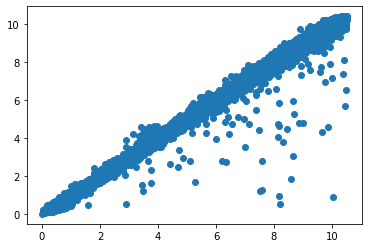

In [46]:
plt.scatter(
    p, 
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    )
)